In [1]:
%pip install jax jaxlib equinox optax pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


/opt/anaconda3/envs/projectsentiment/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
u = np.load("burgers_u.npy")  # Shape: (101, 256)
x = np.load("burgers_x.npy")  # Shape: (256,)
u = torch.tensor(u, dtype=torch.float32).unsqueeze(0)  # [1, T, X]


In [3]:
class BurgersDataset(Dataset):
    def __init__(self, u_seq):
        self.inputs = u_seq[:, :-1]    # [1, 100, 256]
        self.targets = u_seq[:, 1:]    # [1, 100, 256]

    def __len__(self):
        return self.inputs.shape[1]

    def __getitem__(self, idx):
        return self.inputs[0, idx], self.targets[0, idx]

dataloader = DataLoader(BurgersDataset(u), batch_size=16, shuffle=True)


In [ ]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        
        return torch.einsum("bim, iom -> bom", input, weights)

    def forward(self, x):
        B, C, N = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)  # [B, C, N//2+1]
        out_ft = torch.zeros(B, self.out_channels, x_ft.size(-1), device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=N, dim=-1)
        return x

In [ ]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.fc0 = nn.Linear(1, width)

        self.conv1 = SpectralConv1d(width, width, modes)
        self.conv2 = SpectralConv1d(width, width, modes)
        self.w1 = nn.Conv1d(width, width, 1)
        self.w2 = nn.Conv1d(width, width, 1)

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  
        x = self.fc0(x)      
        x = x.permute(0, 2, 1)

        x = torch.relu(self.conv1(x) + self.w1(x))
        x = torch.relu(self.conv2(x) + self.w2(x))

        x = x.permute(0, 2, 1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x).squeeze(-1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO1d(modes=16, width=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [11]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.6f}")

Epoch 1, Loss: 2.831592
Epoch 2, Loss: 0.979863
Epoch 3, Loss: 0.266593
Epoch 4, Loss: 0.088232
Epoch 5, Loss: 0.083990
Epoch 6, Loss: 0.031443
Epoch 7, Loss: 0.021959
Epoch 8, Loss: 0.016928
Epoch 9, Loss: 0.010358
Epoch 10, Loss: 0.005996
Epoch 11, Loss: 0.003875
Epoch 12, Loss: 0.002745
Epoch 13, Loss: 0.001776
Epoch 14, Loss: 0.001265
Epoch 15, Loss: 0.000872
Epoch 16, Loss: 0.000658
Epoch 17, Loss: 0.000531
Epoch 18, Loss: 0.000388
Epoch 19, Loss: 0.000320
Epoch 20, Loss: 0.000297


In [14]:
torch.save(model.state_dict(), "fno1d_burgers.pth")

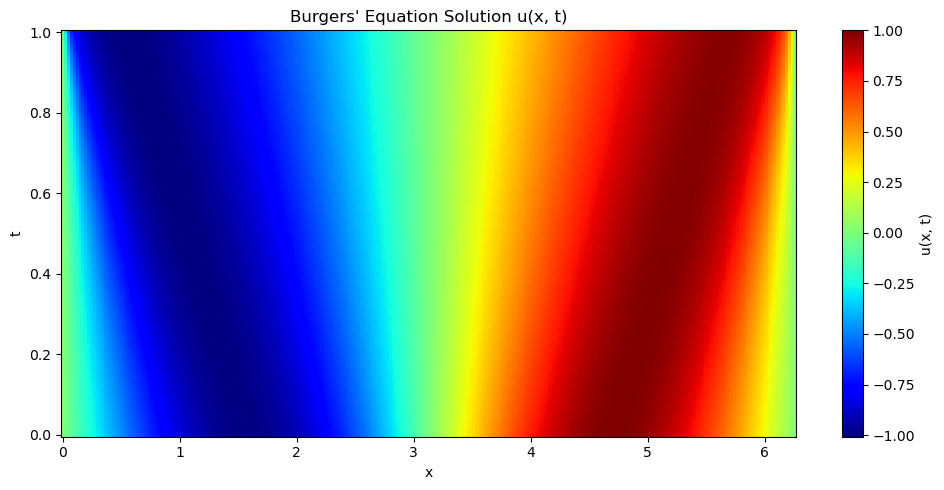

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load your data
u = np.load("burgers_u.npy")  # Shape: (101, 256)
x = np.load("burgers_x.npy")  # Shape: (256,)
t = np.linspace(0, 1, u.shape[0])  


T, X = np.meshgrid(t, x, indexing='ij')  

# Plot the full solution as a heatmap
plt.figure(figsize=(10, 5))
plt.pcolormesh(X, T, u, shading='auto', cmap='jet')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burgers' Equation Solution u(x, t)")
plt.tight_layout()
plt.show()

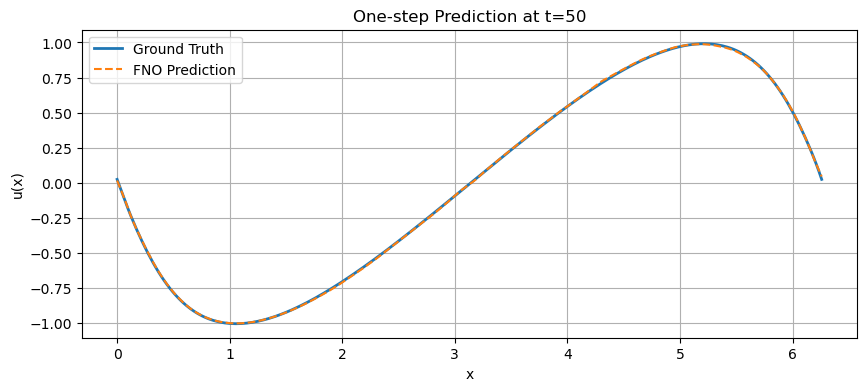

In [ ]:
import torch
import matplotlib.pyplot as plt


model.load_state_dict(torch.load("fno1d_burgers.pth"))
model.eval()


t_index = 50
u_t = u[t_index]       # shape: [256]
u_true = u[t_index+1]  # shape: [256]

with torch.no_grad():
    pred = model(torch.tensor(u_t).unsqueeze(0).to(torch.float32)).squeeze(0)


plt.figure(figsize=(10, 4))
plt.plot(x, u_true, label='Ground Truth', linewidth=2)
plt.plot(x, pred.numpy(), label='FNO Prediction', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'One-step Prediction at t={t_index}')
plt.legend()
plt.grid()
plt.show()

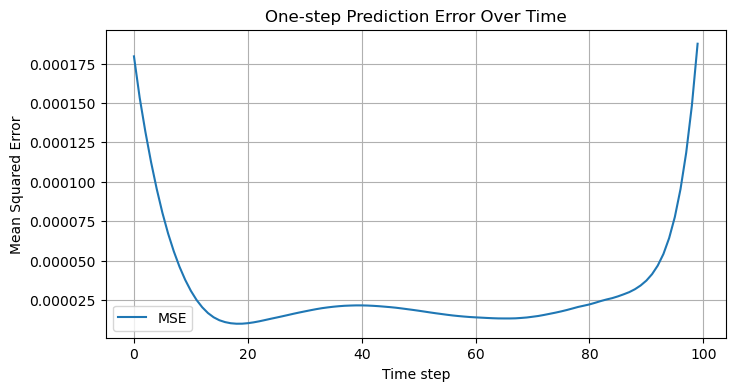

In [ ]:
errors = []

with torch.no_grad():
    for t_index in range(u.shape[0] - 1):
        u_t = u[t_index]
        u_true = u[t_index + 1]
        pred = model(torch.tensor(u_t).unsqueeze(0).to(torch.float32)).squeeze(0)
        mse = torch.mean((pred - torch.tensor(u_true))**2).item()
        errors.append(mse)
        
plt.figure(figsize=(8, 4))
plt.plot(errors, label='MSE')
plt.xlabel('Time step')
plt.ylabel('Mean Squared Error')
plt.title('One-step Prediction Error Over Time')
plt.grid()
plt.legend()
plt.show()

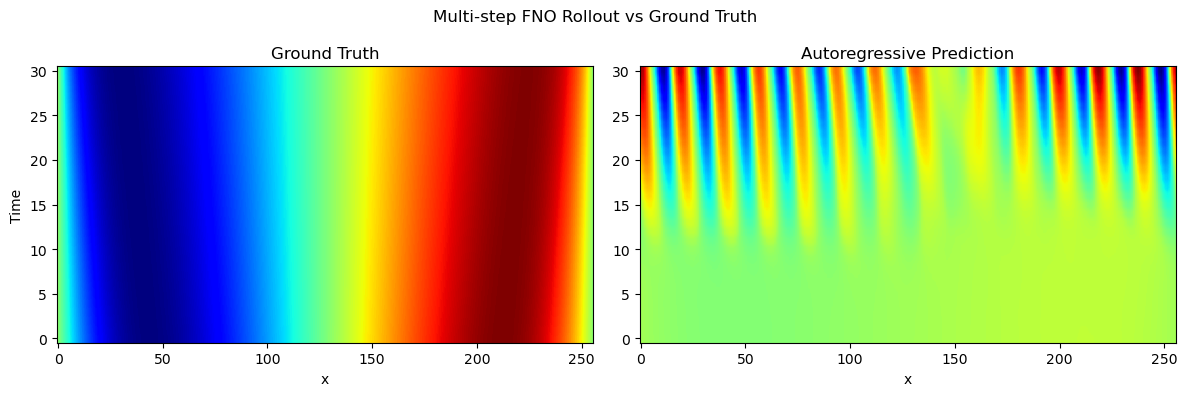

In [ ]:
steps = 30  # how many steps to rollout
start_t = 50
rollout = [u[start_t]]  # initial condition

with torch.no_grad():
    for _ in range(steps):
        next_u = model(torch.tensor(rollout[-1]).unsqueeze(0).to(torch.float32)).squeeze(0)
        rollout.append(next_u.numpy())

rollout = np.array(rollout)  # shape: [steps+1, 256]
ground_truth = u[start_t:start_t+steps+1]


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(ground_truth, aspect='auto', origin='lower', cmap='jet')
axs[0].set_title("Ground Truth")
axs[0].set_ylabel("Time")
axs[0].set_xlabel("x")

axs[1].imshow(rollout, aspect='auto', origin='lower', cmap='jet')
axs[1].set_title("Autoregressive Prediction")
axs[1].set_xlabel("x")

plt.suptitle("Multi-step FNO Rollout vs Ground Truth")
plt.tight_layout()
plt.show()